In [63]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
import os
import torch
from skimage import io
from skimage.measure.simple_metrics import compare_psnr, compare_mse
import sys  
from demo_utils import *
%matplotlib notebook


### Load the trained bias free models

In [67]:
data_base = 'data/'
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 


# Select a model
model = 'dncnn' 

# # select the noise range models have been trained on. 
l = 0  # lower bound of training range 
h = 100 # higher bound of training range

BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))


## Interpretation: Nonlinear adaptive filtering

For a given image, and different levels of noise, find at the adaptive filters computed for any of the pixels

### Interactive filter visualization

<IPython.core.display.Javascript object>


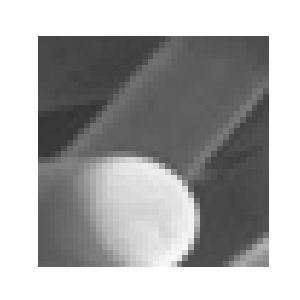

In [68]:
# choose clean image
image_num = 38
clean_im = single_image_loader(test_folder_path, image_num)
clean_im = clean_im[100:140, 100:140]
dim1, dim2 = clean_im.shape
f , axs = plt.subplots(1,1 , figsize=(3,3))    
axs.imshow(clean_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');


<IPython.core.display.Javascript object>


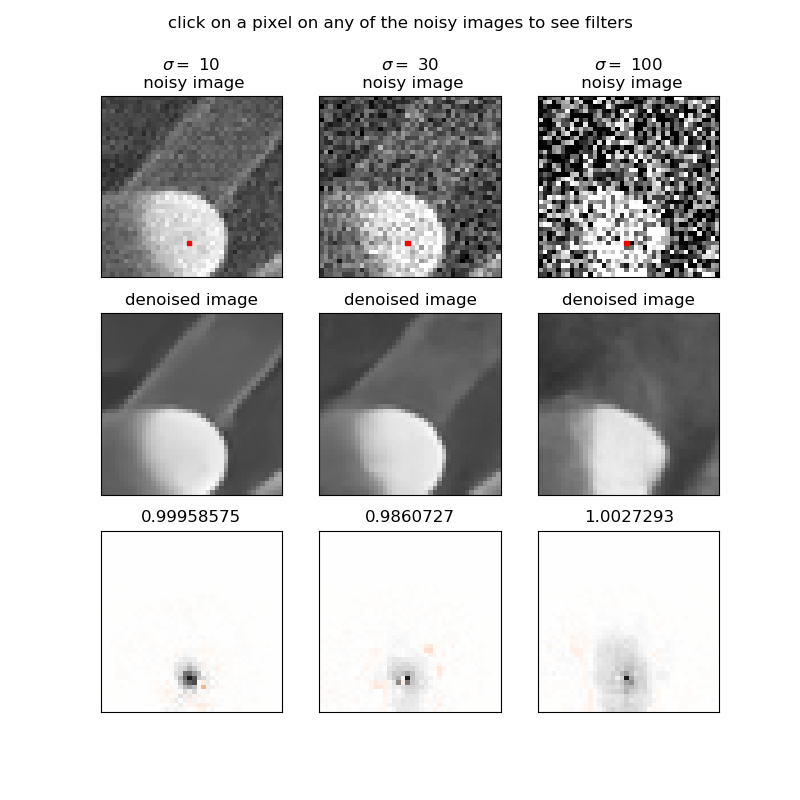

In [69]:
%matplotlib notebook

# choose noise levels 
noise_levels = [10,30, 100] # relative to image intenstities in range (0,255)

global residual_imgs, input_imgs
input_imgs = []
residual_imgs = []

fig = plt.figure(figsize = (8,8))
fig.suptitle('click on a pixel on any of the noisy images to see filters')
plt.axis('off')
ax_names=[]

for j in range(len(noise_levels)):
    # add noise
    noisy_im, _ = add_noise(clean_im.reshape(1,dim1,dim2), noise_levels[j], 'S') 
    # plot noisy
    ax = fig.add_subplot(3,len(noise_levels),j+1)
    ax.imshow(noisy_im[0], 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title(r'$\sigma = $ ' + str(noise_levels[j]) + '\n noisy image')
    ax_names.append(ax)  

    # denoise
    inp_test = torch.tensor(noisy_im.astype('float32'),requires_grad=True).unsqueeze(1)
    input_imgs.append(inp_test)
    residual= BF_CNN(inp_test)
    residual_imgs.append(residual)
    denoised = residual.squeeze(0).squeeze(0).data.numpy()
    
    # plot denoised
    ax = fig.add_subplot(3,len(noise_levels),j+len(noise_levels)+1)
    ax.imshow(denoised, 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title( 'denoised image')    
    
global last_pa 
last_pa = []

ix, iy = 0, 0
def onclick(event):

    global ix, iy
    ix, iy = int(event.xdata), int(event.ydata)
    
    # remove previous pixel marker
    if len(last_pa) != 0:       
        for i in range(len(last_pa)):
            last_pa[i].set_visible(False)         
    
    for j in range(len(noise_levels)):
        ax = fig.add_subplot(fig.add_subplot(3,len(noise_levels),j+len(noise_levels)*2+1))
        filt = torch.autograd.grad(residual_imgs[j][0,0,iy,ix], input_imgs[j], retain_graph=True)[0][0,0].data.numpy() 
        limit =  max(np.abs(np.min( filt)), np.abs(np.max( filt)))
        ax.imshow(filt, 'RdGy', vmin= -limit, vmax = limit)
        ax.set_title(str(np.sum(filt)))
        ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
        pa = patches.Rectangle((ix-.5,iy-.5), width=1, height=1,edgecolor = [1,0,0], angle=0.0, facecolor='red', lw=1)
        ax_names[j].add_patch(pa)
        last_pa.append(pa)
        
cid = fig.canvas.mpl_connect('button_press_event', onclick);


In [53]:
# run this to exit the interactive mode
f.canvas.mpl_disconnect(cid)


<IPython.core.display.Javascript object>


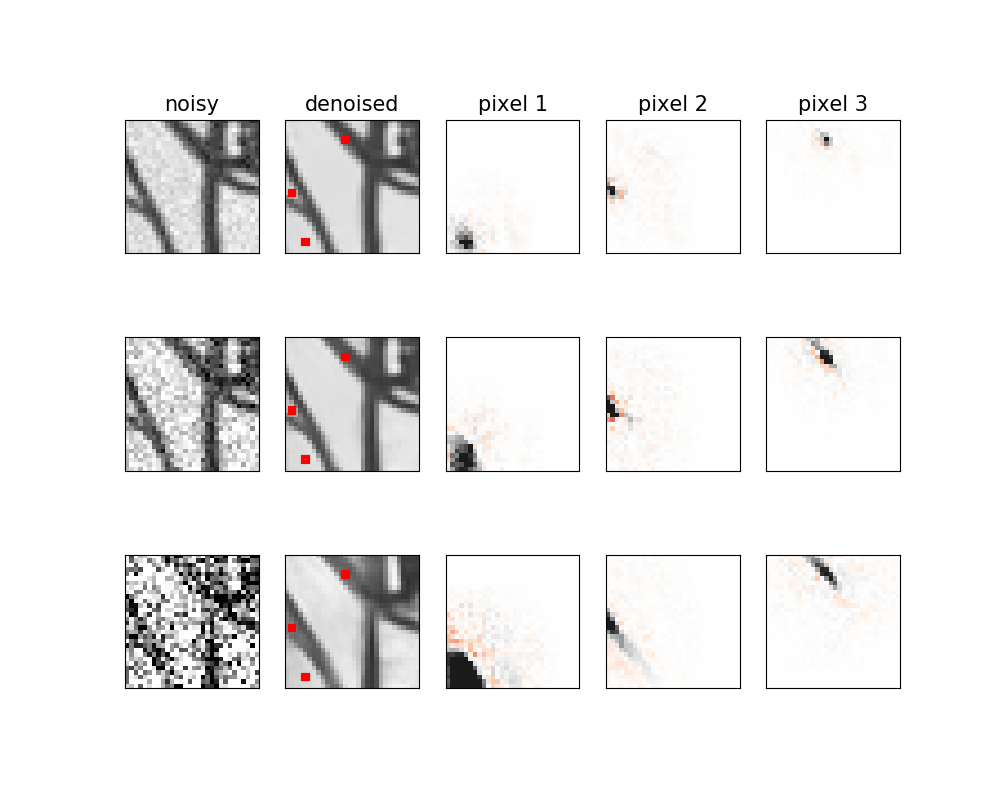

In [54]:
# Image in the paper

folder_path = precomputed_base +'/'+model + '/bias_free'

noise_levels = [10,30,100]

pixels_rows = [27, 16, 4]
pixels_cols = [4 , 1 ,13]



f , axs = plt.subplots(len(noise_levels),2+len(pixels_rows) , figsize=(10,8))
for j in range(len(noise_levels)): 
    A = np.load(folder_path + '/Jacobian_'+str(noise_levels[j])+'.npy')
    noisy_im = np.load(folder_path + '/noisy_im_'+str(noise_levels[j])+'.npy')
    denoised = np.load(folder_path + '/im_denoised_'+str(noise_levels[j])+'.npy')

    
    dim1, dim2 = noisy_im.shape
    N = A.shape[0]
    I = np.eye(N) 

    axs[j,0].imshow(noisy_im, 'gray', vmin = 0, vmax = 1)
    axs[j,0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

    axs[j,1].imshow(denoised, 'gray', vmin = 0, vmax = 1)
    axs[j,1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
        
    for r,c in zip(pixels_rows, pixels_cols): 
        pa = patches.Rectangle((c-.5,r-.5), width=1, height=1, angle=0.0, edgecolor = [1,0,0], facecolor='none', lw=3)
        axs[j, 1].add_patch(pa)
        
    for p in range(len(pixels_cols)):     
        r = pixels_rows[p]
        c = pixels_cols[p]
        limit =  max(np.abs(np.min( (I - A)[dim1*r+c ,:])), np.abs(np.max( (I - A)[dim1*r+c,:])))/2
        axs[j,p+2].imshow((I - A)[dim1*r+c,:].reshape(dim1,dim2), 'RdGy', vmin = -limit, vmax = limit)
        axs[j,p+2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

axs[0,0].set_title('noisy', fontsize=15)
axs[0,1].set_title('denoised', fontsize=15)
axs[0,2].set_title('pixel 1', fontsize=15)
axs[0,3].set_title('pixel 2', fontsize=15)
axs[0,4].set_title('pixel 3', fontsize=15);

        

# Interpretation: projection onto adaptive signal subspace

In [55]:
for j in range(len(noise_levels)): 
    A = np.load(folder_path + '/Jacobian_'+str(noise_levels[j])+'.npy')    
    U , S, V = np.linalg.svd(I - A)
    ax.plot(S, '-o', alpha = 1,label=r'$\sigma = $'+str(noise_levels[j]), markersize = 2,linewidth=1)


<IPython.core.display.Javascript object>


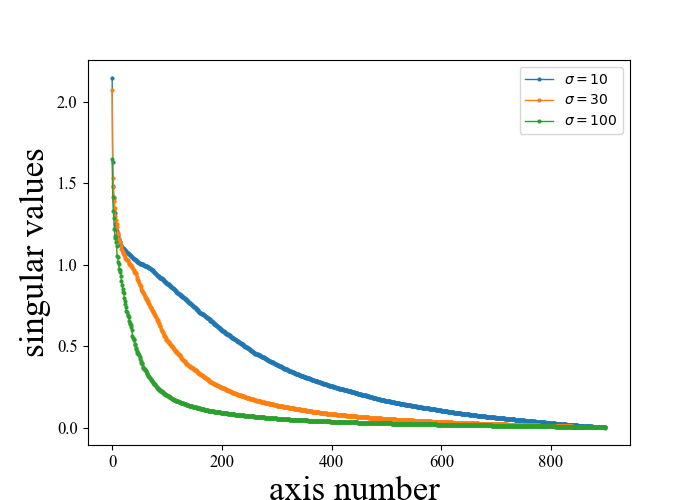

In [56]:
noise_levels = [10,30,100]

f, ax = plt.subplots(1,1,figsize = (7,5))

ax.set_xlabel('axis number ', fontsize = 25, fontname= 'Times New Roman')
ax.set_ylabel('singular values', fontsize = 25, fontname= 'Times New Roman')   

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    tick.label.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    tick.label.set_fontname("Times New Roman")
    
for j in range(len(noise_levels)): 
    A = np.load(folder_path + '/Jacobian_'+str(noise_levels[j])+'.npy')    
    U , S, V = np.linalg.svd(I - A)
    ax.plot(S, '-o', alpha = 1,label=r'$\sigma = $'+str(noise_levels[j]), markersize = 2,linewidth=1)
ax.legend();    


### Select a number of top singular vectors for visualization

These can be interpreted as some of the axes of the singnal subspace

<IPython.core.display.Javascript object>


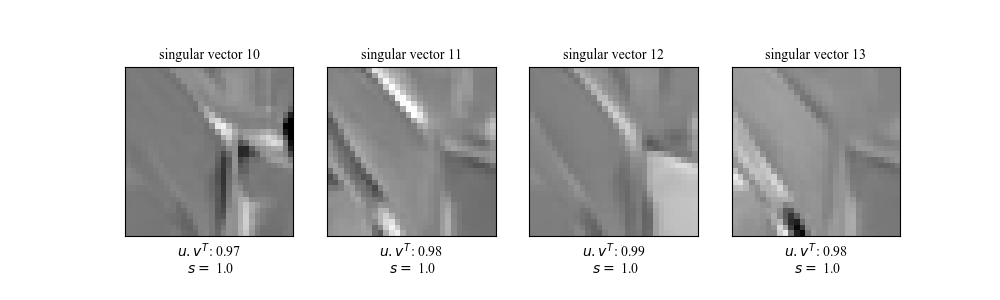

In [58]:
# % matplotlib inline

sing_vect_n = [10,11,12,13]

limit =  max(np.abs(np.min( U[:,sing_vect_n])), np.abs(np.max(U[:,sing_vect_n])))


f , axs = plt.subplots(1,len(sing_vect_n) , figsize=(10,3))    
plt.subplots_adjust()
for i in range(len(sing_vect_n)):
    u = U[:,sing_vect_n[i]]
    v = V[sing_vect_n[i],:]
    axs[i].imshow(u.reshape(dim1,dim2), 'gray', vmin=-limit/2, vmax = limit/2)
    axs[i].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[i].set_xlabel(r'$u.v^T$: '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(S[sing_vect_n[i]],1)),
                      fontsize = 10, fontname= 'Times New Roman');




<IPython.core.display.Javascript object>


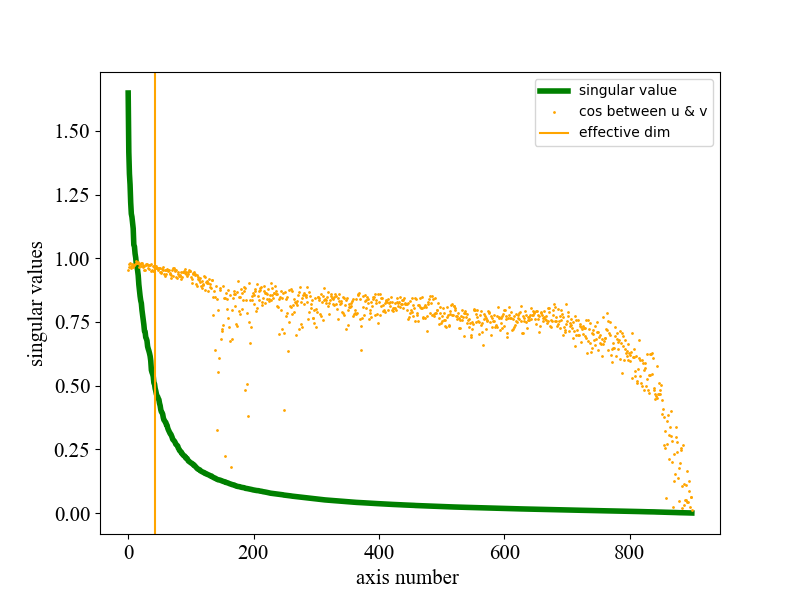

In [60]:
# % matplotlib inline


subspace_dim = int(np.sum((S)**2))

uvdots = []
for j in range(N):
    v = V[j,:]
    u = U[:,j]
    uvdots.append(abs(np.dot(v,u)))


f, ax = plt.subplots(1,1,figsize = (8,6))

ax.plot(S, alpha = 1, label='singular value', color = 'green', linewidth=4)
ax.plot(uvdots, '.', color = 'orange', markersize=2, label = 'cos between u & v')   
ax.axvline(subspace_dim, color='orange', alpha = 1, label = 'effective dim')     


ax.set_xlabel('axis number ', fontsize = 15, fontname= 'Times New Roman')
ax.set_ylabel('singular values', fontsize = 15, fontname= 'Times New Roman')   
plt.legend()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    tick.label.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    tick.label.set_fontname("Times New Roman");




### Subspace dimensionality as a function of noise, across many images

If you want to use a new set of patches, run calc_subspace_dims.py module from the code directory to calculate the dimensionalities of subspaces of new images.

Otherwise, skip this step, and load the existing results. 


<IPython.core.display.Javascript object>


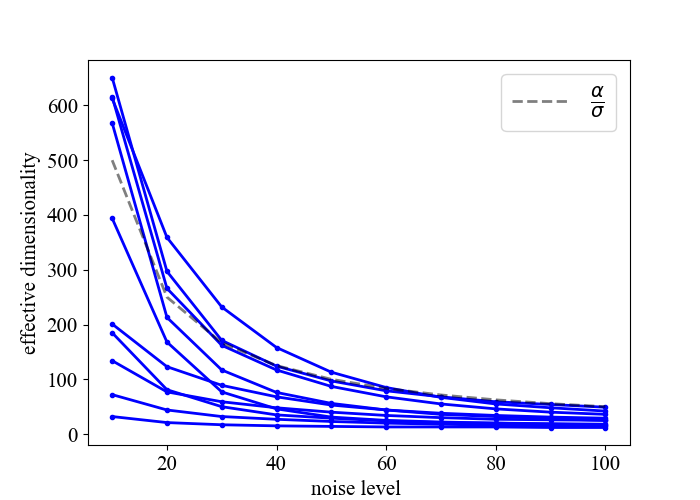

In [61]:
# % matplotlib inline

subspace_dims = np.load(folder_path + '/subspace_dims.npy',allow_pickle=True).item()

f, ax = plt.subplots(1,1,figsize = (7,5))

for i, dims in subspace_dims.items():
    ax.plot(range(10,110,10), dims, alpha = 1, linewidth=2, marker = '.', color='blue')

ax.set_xlabel('noise level ',fontsize = 15, fontname= 'Times New Roman')
ax.set_ylabel('effective dimensionality', fontsize = 15, fontname= 'Times New Roman')   
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    tick.label.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontname("Times New Roman")

ax.plot(range(10,110,10), [(5000/x) for x in range(10,110,10)], 'k--', lw = 2, label = r'$\frac{\alpha}{\sigma}$', alpha = .5)    
ax.legend(fontsize=20);
